In [72]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
plt.style.use('jt')

In [2]:
# Use RELOAD=True mode to import pickles and avoid retraining models 
from joblib import dump, load
model_fpath = 'saved_models/3_'
RELOAD = True

# Exercise 1)
Build a classifier for the MNIST dataset tha achieves over 97% accuracy on the test set

In [3]:
if RELOAD:
    mnist = load(model_fpath+'mnist.joblib')
else:
    mnist = fetch_openml('mnist_784', version=1)
    dump(mnist, model_fpath+'mnist.joblib')

X, y = mnist['data'], mnist['target'].astype(np.uint8)

In [4]:
# recall data is already shuffled into training and test set
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]

We'll start with a small set and to write the code and then run on the full training set

In [5]:
X_train_small, y_train_small = X_train[:5000], y_train[:5000]
X_test_small, y_test_small = X_test[:5000], y_test[:5000]

In [6]:
knn_clf = KNeighborsClassifier()
knn_preds = cross_val_predict(knn_clf, X_train_small, y_train_small, cv=3, verbose=2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   24.7s finished


In [11]:
def print_model_scores(y_actual, y_preds, average=None):
    precision = precision_score(y_actual, y_preds, average=average)
    recall = recall_score(y_actual, y_preds, average=average)
    f1 = f1_score(y_actual, y_preds, average=average)
    accuracy = accuracy_score(y_actual, y_preds)

    print('Model results')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1: {f1}')

In [8]:
print_model_scores(y_train_small, knn_preds, 'macro')

Model results
Accuracy: 0.9216
Precision: 0.9250926365448813
Recall: 0.9200168298628594
F1: 0.921287739432865


In [51]:
param_grid = [
    {'weights': ['uniform', 'distance'], 'n_neighbors': np.r_[1:10]}
]
grid_search = GridSearchCV(knn_clf, param_grid, cv=3)
grid_search.fit(X_train_small, y_train_small)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid=[{'n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [52]:
grid_clf = grid_search.best_estimator_
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [53]:
grid_preds = cross_val_predict(grid_clf, X_train_small, y_train_small, cv=3)
print_model_scores(y_train_small, grid_preds, 'macro')

Model results
Precision: 0.9316239364223113
Recall: 0.9279879556944662
F1: 0.9289948152946156


Grid search on this model trained with a small sample slightly improved results and yields n_neighbours = 4. With this, I can reduce the search space for n_neighbors to say range(3, 6) for the full dataset to save some time during training as the full dataset is very large

In [55]:
# Grid Search for full dataset
if RELOAD:
    grid_search = load(model_fpath + 'ex1_knn.joblib')
else:
    start_time = time.time()
    param_grid = [{'weights':['uniform', 'distance'], 'n_neighbors':np.r_[3:7]}]
    print("Initiating GridSearch")
    grid_search = GridSearchCV(knn_clf, param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    print(f'GridSearch complete in {(time.time()-start_time)/60.0:.2f} minutes')
    dump(grid_search, model_fpath+'ex1_knn.joblib')

Initiating GridSearch
GridSearch complete in 568.43 minutes


AttributeError: 'GridSearchCV' object has no attribute 'best_estimator'

In [57]:
start_time = time.time()
grid_clf = grid_search.best_estimator_
print(f'Found best params {grid_search.best_params_}')

print(f'Initiating CrossValPredict on training set')
grid_preds = cross_val_predict(grid_clf, X_train, y_train, cv=3)
print(f'Validation completed in {(time.time()-start_time)/60.0:.2f} minutes')
print_model_scores(y_train, grid_preds, average='macro')

Found best params {'n_neighbors': 4, 'weights': 'distance'}
Initiating CrossValPredict on training set
Validation completed in 800.63 minutes
Model results
Precision: [0.97985012 0.96184739 0.98721934 0.96971193 0.97932233 0.96290829
 0.97712855 0.96174433 0.97943123 0.94711618]
Recall: [0.9934155  0.99466034 0.95938234 0.96085467 0.9647381  0.96255303
 0.98901656 0.97509976 0.93590839 0.96335519]
F1: [0.98658618 0.97797871 0.9731018  0.96526299 0.97197551 0.96273063
 0.98303661 0.968376   0.95717532 0.95516667]


In [75]:
test_set_preds = cross_val_predict(grid_clf, X_test, y_test, cv=3)

In [76]:
print_model_scores(y_test, test_set_preds, average='macro')

Model results
Precision: 0.9421027040033261
Recall: 0.9402735042228934
F1: 0.9407514123508827


Model is slightly overfitting the train set. Perhaps scaling can help. Since we found the best parameters, there's no need to continue with the gridsearch, but just in case I will perform another gridsearch on the smaller to check if the scaling affects the model parameters

(array([0.10957143, 0.12503175, 0.11095238, 0.11334921, 0.10831746,
        0.10020635, 0.10914286, 0.1157619 , 0.10833333, 0.11044444]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

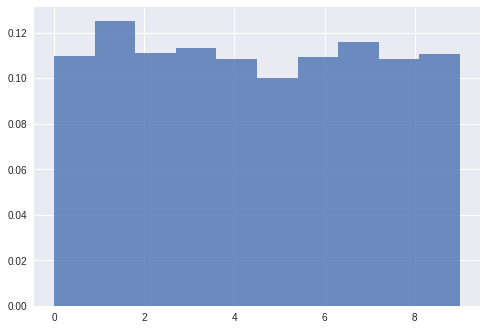

In [26]:
plt.hist(y, density=True, alpha=0.8)
plt.show()

Looks like the numbers are somewhat uniformly distributed. What if we apply normalisation instead of Standardisation?

In [29]:
small_scale_knn = KNeighborsClassifier()
scaler = MinMaxScaler()
X_train_small_scaled = scaler.fit_transform(X_train_small)
X_test_small_scaled = scaler.fit_transform(X_test_small)

start_time = time.time()
print(f'Initializing small scale grid search')
scaled_grid_params = [{
    'weights':['uniform', 'distance'], 'n_neighbors':np.r_[1:10]
}]
scaled_gs = GridSearchCV(small_scale_knn, scaled_grid_params, cv=3)
scaled_gs.fit(X_train_small_scaled, y_train_small)
print(f'Done in {(time.time() - start_time)/60.0 :.2f} minutes')
print(f'Found best parameters: {scaled_gs.best_params_}')
best_small_scaled = scaled_gs.best_estimator_

start_time = time.time()
print(f'Performing predictions on training set...')
small_scaled_train_pred = cross_val_predict(best_small_scaled, 
                                            X_train_small_scaled, y_train_small, cv=3)
print(f'Done in {(time.time() - start_time)/60.0 :.2f} minutes')
print(f'Small scale training set predictions')
print_model_scores(y_train_small, small_scaled_train_pred, average='macro')

start_time = time.time()
print(f'Performing predictions on test set...')
small_scaled_test_pred = cross_val_predict(best_small_scaled, 
                                           X_test_small_scaled, y_test_small, cv=3)
print(f'Done in {(time.time() - start_time)/60.0 :.2f} minutes')
print(f'Small scale test set predictions')
print_model_scores(y_test_small, small_scaled_test_pred, average='macro')

Initializing small scale grid search
Done in 7.10 minutes
Found best parameters: {'n_neighbors': 4, 'weights': 'distance'}
Performing predictions on training set...
Done in 0.38 minutes
Small scale training set predictions
Model results
Precision: 0.9318254917568485
Recall: 0.9281655755878944
F1: 0.9291717352860764
Performing predictions on test set...
Done in 0.39 minutes
Small scale test set predictions
Model results
Precision: 0.9208179213265941
Recall: 0.91791024337353
F1: 0.9183627833232635


Looks like MinMaxScaling helps! Let's use this and the best parameters to create our predictor.

In [5]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [13]:
weights = scaled_gs.best_params_['weights'] # distance
n_neighbors = scaled_gs.best_params_['n_neighbors'] # 4

knn_clf = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)

NameError: name 'scaled_gs' is not defined

In [41]:
start_time = time.time()
print(f'Fitting to training set...')
knn_clf.fit(X_train_scaled, y_train)
print(f'Done in {(time.time() - start_time)/60.0 :.2f} minutes')

Fitting to training set...
Done in 0.25 minutes


In [43]:
start_time = time.time()
print(f'Predicting test set...')
y_preds = knn_clf.predict(X_test_scaled)
print(f'Done in {(time.time() - start_time)/60.0 :.2f} minutes')

Predicting test set...
Done in 13.21 minutes


In [54]:
print_model_scores(y_test, y_preds, average='macro')

Model results
Accuracy: 0.9714
Precision: 0.9715597201945959
Recall: 0.9710823052664403
F1: 0.971224084176584


Done!

# Exercise 2)
Create a function that can shift an MNIST image in any direction. Then for each image in the training set, create four shifted copies and add them to the training set. Re-train the model and measure its accuracy

In [83]:
test = np.ones((5,5), dtype='uint8') * np.r_[1:6]
test

array([[1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5]])

In [87]:
shift(test, [0,1]) # shifts col to right

array([[0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4]])

In [85]:
shift(test, [1,0]) # shifts row down

array([[0, 0, 0, 0, 0],
       [1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5]])

In [6]:
from scipy.ndimage import shift

def create_shifted_samples(arr, shift_size=1):
    original_shape = arr.shape
    img_shape = (28,28)
    right_shift = np.array([0,0,1]) * shift_size
    down_shift = np.array([0,1,0]) * shift_size
    left_shift, up_shift = -1*right_shift, -1*down_shift
    
    shaped_arr = np.apply_along_axis(np.reshape, 1, arr, img_shape)
    right_shifted = shift(shaped_arr, right_shift).reshape(original_shape)
    down_shifted = shift(shaped_arr, down_shift).reshape(original_shape)
    left_shifted = shift(shaped_arr, left_shift).reshape(original_shape)
    up_shifted = shift(shaped_arr, up_shift).reshape(original_shape)
    
    return np.r_[right_shifted, down_shifted, left_shifted, up_shifted]

In [7]:
shifted_train_set = create_shifted_samples(X_train_scaled)
X_train_scaled_shifted = np.r_[X_train_scaled, shifted_train_set]

In [ ]:
# X_test_scaled_shifted = create_shifted_samples(X_test_scaled)
# X_test_scaled_shifted = np.r_[X_test_scaled, X_test_scaled_shifted]

In [8]:
y_train_shifted = np.tile(y_train, 5)
# y_test_shifted = np.tile(y_test, 5)

In [237]:
# Check that there are the same number of observations in X and y
# X_train_scaled_shifted.shape[0] == y_train_shifted.shape[0]

True

In [9]:
n_neighbors = 4
weights = 'distance'

shifted_knn_clf = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)

start_time = time.time()
print(f'Fitting to training set...')
shifted_knn_clf.fit(X_train_scaled_shifted, y_train_shifted)
print(f'Done in {(time.time() - start_time)/60.0 :.2f} minutes')

Fitting to training set...
Done in 0.84 minutes


In [10]:
start_time = time.time()
print(f'Predicting test set...')
y_preds = shifted_knn_clf.predict(X_test_scaled)
print(f'Done in {(time.time() - start_time)/60.0 :.2f} minutes')



Predicting test set...
Done in 69.92 minutes


NameError: name 'print_model_scores' is not defined

In [12]:
print_model_scores(y_test, y_preds, average='macro')

Model results
Accuracy: 0.9764
Precision: 0.9767313811568235
Recall: 0.9761507279337562
F1: 0.97636443628852


Slight gains

# 3) Tackle the titanic dataset
I'll keep this attempt simple and short so I don't spend too much time on it for now

In [15]:
titanic_fpath = 'datasets/titanic/train.csv'
test_set_fpath = 'datasets/titanic/test.csv'
test_df = pd.read_csv(test_set_fpath)
df = pd.read_csv(titanic_fpath)

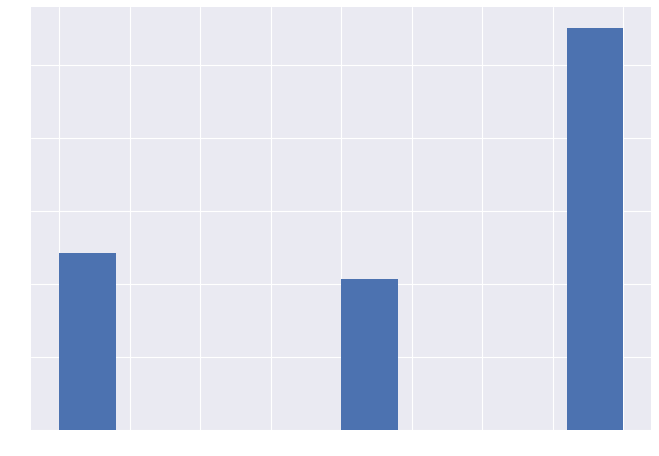

In [73]:
df['Pclass'].hist(density=True)
plt.show()

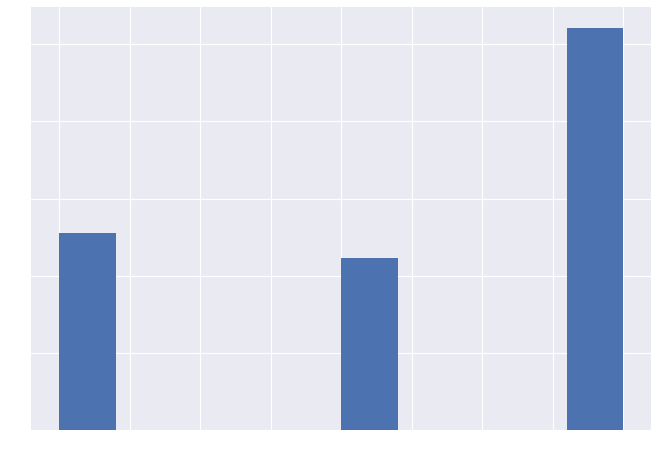

In [74]:
test_df['Pclass'].hist(density=True)
plt.show()

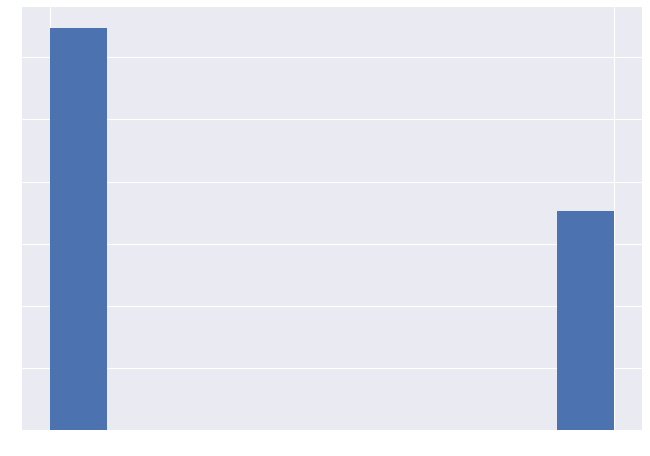

In [75]:
df['Sex'].hist(density=True)
plt.show()

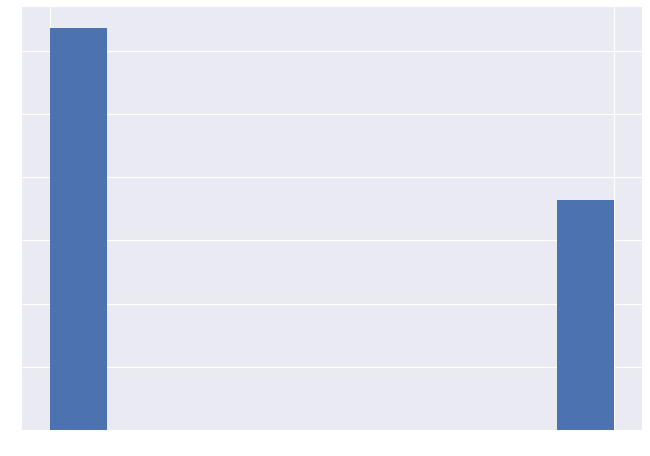

In [76]:
test_df['Sex'].hist(density=True)
plt.show()

From the quick plots above, it looks like the train and test set have already been stratified, let's make the assumption that it has

In [6]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [27]:
df['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

Some Age values are missing, let's pick the columns we need and apply transformations. 

In [130]:
num_cols = ['Age', 'SibSp', 'Parch']
cat_cols = ['Pclass', 'Sex']

num_attribs = df[num_cols]
cat_attribs = df[cat_cols]

X_train_df = df[num_cols + cat_cols]
y_train_df = df['Survived'].copy()

X_test_df = test_df[num_cols + cat_cols]

Preprocessing stage

In [138]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

prep_pipeline = ColumnTransformer([
    ('numerical', num_pipeline, num_cols),
    ('categorical', OneHotEncoder(), cat_cols)
])

X_train = prep_pipeline.fit_transform(X_train_df)
X_train.shape

(891, 8)

Let's test some classifiers, see how they perform

In [168]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

predict_pipeline = Pipeline([
    ('prep', prep_pipeline),
    ('predict', SGDClassifier())
])

n_jobs = -1
random_state = 42

param_grid = [
    {
        'prep__numerical__imputer__strategy': ['mean', 'median', 'most_frequent'],
        'prep__numerical__scaler': [MinMaxScaler(), StandardScaler()],
        'predict': [SGDClassifier(n_jobs=n_jobs, random_state=random_state)],
        'predict__loss': ['hinge', 'log', 'perceptron'],
        'predict__penalty': ['l2', 'l1', 'elasticnet'],
        'predict__max_iter' : np.r_[1000 : 10000 : 1000]
    },
    {
        'prep__numerical__imputer__strategy': ['mean', 'median', 'most_frequent'],
        'prep__numerical__scaler': [MinMaxScaler(), StandardScaler()],
        'predict': [RandomForestClassifier(n_jobs=n_jobs, random_state=random_state)],
        'predict__n_estimators': np.r_[100:500:100],
        'predict__criterion': ['gini', 'entropy'],
        'predict__max_features': ['auto','log2']
    },
    {
        'prep__numerical__imputer__strategy': ['mean', 'median', 'most_frequent'],
        'prep__numerical__scaler': [MinMaxScaler(), StandardScaler()],
        'predict': [SVC(random_state=random_state)],
        'predict__C': np.r_[1:10],
        'predict__kernel': ['linear', 'rbf', 'sigmoid'],
        'predict__gamma': ['scale', 'auto']
    },
    {
        'prep__numerical__imputer__strategy': ['mean', 'median', 'most_frequent'],
        'prep__numerical__scaler': [MinMaxScaler(), StandardScaler()],
        'predict': [KNeighborsClassifier(n_jobs=n_jobs)],
        'predict__n_neighbors': np.r_[2:10],
        'predict__weights': ['uniform', 'distance'],
        'predict__algorithm': ['auto','ball_tree', 'kd_tree']
    }
]

In [174]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(predict_pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train_df, y_train_df)

best_estimator = grid_search.best_estimator_
best_param = grid_search.best_params_
best_param

Fitting 5 folds for each of 1194 candidates, totalling 5970 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 5970 out of 5970 | elapsed:  5.0min finished


{'predict': SVC(C=2, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
     max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
     verbose=False),
 'predict__C': 2,
 'predict__gamma': 'auto',
 'predict__kernel': 'rbf',
 'prep__numerical__imputer__strategy': 'mean',
 'prep__numerical__scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

In [186]:
grid_search.best_score_

0.8294017952419811

Somewhat decent score for a quick attempt. There's more that can be done to improve the model but i'll leave this as future work

* What is SibSp and Parch? how do the affect Survival?
* Are there correlations between class/location of embark and survival?
* Feature Engineering
    * Some names have titles, can we extract them and use them?
* Test other models
* Test RandomSearchCV